# Vehicle Detection

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [1]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Histogram of Oriented Gradients (HOG) feature extraction

I started by reading in all the vehicle and non-vehicle images by using glob.glob function.

In [2]:
# Divide up into cars and notcars
images = glob.glob('./test_images/**/*.jpeg', recursive=True)
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

I defined the data_look function to receive vehicle and non-vehicle dataset and return some characteristics of them.

In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

I visualized an example of one of each of the vehicle and non-vehicle dataset.

Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8


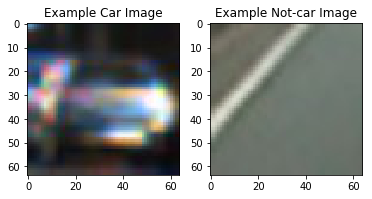

In [4]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### Feature Extraction and Normalization

At first, I defined the functions for feature extraction.

- get_hog_features: This is a sub fuction of extract_features function. This function returns HOG features and visualization.
- bin_spatial: This is a sub function of extract_features function. This function computes and returns binned color features.
- color_hist: This is a sub function of extract_features function. This function computes and returns color histogram features.
- extract_features: This is a main function of feature extraction. This function extracts and returns features from a list of images.

In [5]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
#def bin_spatial(img, size=(32, 32)):
#    color1 = cv2.resize(img[:,:,0], size).ravel()
#    color2 = cv2.resize(img[:,:,1], size).ravel()
#    color3 = cv2.resize(img[:,:,2], size).ravel()
#    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32), hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat is True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat is True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat is True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

I visualized the hog features of the example image below.

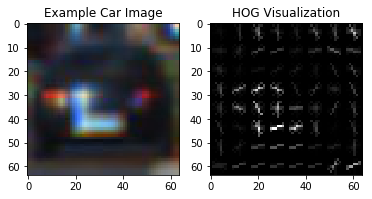

In [6]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

I defined the parameters as follows.

In [7]:
color_space='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True

I extracted the features of vehicle and non-vehicle dataset.

In [8]:
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

I normalized the extracted feature vectors by using sklearn.preprocessing.StandardScaler.fit function.

In [9]:
from sklearn.preprocessing import StandardScaler

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

I visualized the distribution of raw and normalized features of a sample image.

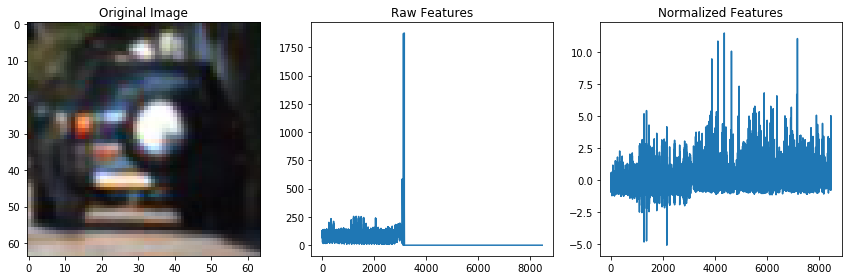

In [10]:
if len(car_features) > 0:
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

I created training and test dataset by splitting dataset by using sklearn.model_selection.train_test_split function.

In [11]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

Here are the values of orientation, pixels per cell, cell per block, and feature vector length.

In [12]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


I trained the model with training dataset by using sklearn.svm.LinerSVC function.

In [13]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

0.84 Seconds to train SVC...


I checked the score of the SVC by printing test accuracy and predicted the labels for 10 samples.

In [14]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  1.0
My SVC predicts:  [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.]
0.00726 Seconds to predict 10 labels with SVC


I saved the training results to svc_pickle.p file by using pickle.dump function.

In [15]:
import pickle

data={
    'svc': svc,
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel
     }

with open('svc_pickle.p', 'wb') as pFile:
    pickle.dump(data, pFile)

## Sliding Window Search

I defined the below functions for Sliding Window Search.

- slide_window: This function takes an image, start and stop positions in both x and y, window size, overlap fraction.
    This function returns a list of windows.
- single_img_features: This function extracts features from a single image window.
    This function is very similar to extract_features(), but just for a single image rather than list of images.
- search_windows: This function takes an image and the list of windows to be searched (output of slide_windows()).
- convert_color: This is a utility function to convert image into the specified color space.
- find_cars: This function extracts features using hog sub-sampling and makes predictions.
- draw_boxes: This is a utility function that takes an image, a list of bounding boxes, and optional color tuple and line thickness as inputs.
    This function draws boxes in that color on the output.

In [16]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(hog_channel, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

I applied the sliding window search to one of my test images.

svc= LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
X_scaler= StandardScaler(copy=True, with_mean=True, with_std=True)
color_space= YCrCb
orient= 9
pix_per_cell= 8
cell_per_block= 2
hog_channel= StandardScaler(copy=True, with_mean=True, with_std=True)
spatial_size= (32, 32)
hist_bins= 32


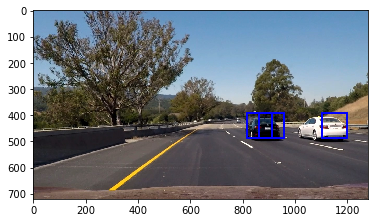

In [17]:
## Load model params
with open('svc_pickle.p', 'rb') as pfile:
    pickle_data = pickle.load(pfile)
    for key in pickle_data:
        exec(key + "= pickle_data['" + str(key) + "']")
    del pickle_data

print("svc=", svc)
print("X_scaler=", X_scaler)
print("color_space=", color_space)
print("orient=", orient)
print("pix_per_cell=", pix_per_cell)
print("cell_per_block=", cell_per_block)
print("hog_channel=", X_scaler)
print("spatial_size=", spatial_size)
print("hist_bins=", hist_bins)   

y_start_stop = [200, 600] # Min and max in y to search in slide_window()

image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [ ]:
ystart = 400
ystop = 600
scale = 1.5
   
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, 
                    cell_per_block, hog_channel, spatial_size, hist_bins)

plt.imshow(out_img)

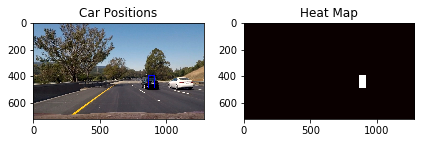

In [20]:
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = hot_windows

# Read in image similar to one shown above 
#image = mpimg.imread('./test_images/test6.jpg')
#heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = np.zeros_like(image[:,:,0])

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [ ]:
import glob
import os
import time

#import matplotlib.pyplot as plt
#from moviepy.video.io.VideoFileClip import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

#from heatmapper import Heatmapper
#from lesson_functions import *
#from solution import search_windows, extract_features, compute_hog_features, convert_color_space

SCALER_PICKLE_FILENAME = 'scaler.joblib.pkl'
SCALED_X_PICKLE_FILENAME = 'scaled_x.joblib.pkl'
SVC_PICKLE_FILENAME = 'svc.joblib.pkl'

cars = []
notcars = []

car_features = None
notcar_features = None
X_scaler = None
scaled_X = None
svc = None

#def convert_color_space(img):
#    if color_space != 'RGB':
#        if color_space == 'HSV':
#            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#        elif color_space == 'LUV':
#            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#        elif color_space == 'HLS':
#            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#        elif color_space == 'YUV':
#            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#        elif color_space == 'YCrCb':
#            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

#    return img

def compute_hog_features(img):
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(img.shape[2]):
            hog_features.append(
                get_hog_features(img[:, :, channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
            )
        return np.array(hog_features)
    else:
        hog_features = get_hog_features(
            img[:, :, hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False
        )
    return hog_features

def compute_features():
    global car_features, notcar_features
    car_features = extract_features(cars)
    notcar_features = extract_features(notcars)


def learn_scale():
    global car_features, notcar_features, X_scaler, scaled_X
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    joblib.dump(X_scaler, SCALER_PICKLE_FILENAME, compress=9)
    scaled_X = X_scaler.transform(X)
    joblib.dump(scaled_X, SCALED_X_PICKLE_FILENAME, compress=9)


def learn():
    global car_features, notcar_features, scaled_X, svc
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    rand_state = np.random.randint(0, 100)
    x_train, x_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    svc = LinearSVC()
    t = time.time()
    svc.fit(x_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(x_test, y_test), 4))
    joblib.dump(svc, SVC_PICKLE_FILENAME, compress=9)
    return svc


def process_image(img):
    global windows
    draw_image = np.copy(img)
    img = img.astype(np.float32) / 255
    img = convert_color(img)

    hog_features = compute_hog_features(img)

    hot_windows = search_windows(img, windows, svc, X_scaler, hog_feat=hog_features)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
#    heatmapper.add_frame_boxes(hot_windows)
#    heatmap = heatmapper.compute_heatmap(img)

#    labels = label(heatmap)

    return draw_labeled_bboxes(draw_image, labels)


def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    return img


images = glob.glob('./test_images/**/*.jpeg', recursive=True)
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

if os.path.isfile(SCALER_PICKLE_FILENAME):
    print('Loader scaler from pickle...')
    X_scaler = joblib.load(SCALER_PICKLE_FILENAME)
    print('Done')
else:
    print('Learning scale from scratch...')
    if car_features is None:
        compute_features()

    learn_scale()
    print('Done')

if os.path.isfile(SVC_PICKLE_FILENAME):
    print('Loading SVC from pickle...')
    svc = joblib.load(SVC_PICKLE_FILENAME)
    print('Done')
else:
    print('Learning SVC from scratch...')
    if car_features is None:
        compute_features()
    if scaled_X is None:
        scaled_X = joblib.load(SCALED_X_PICKLE_FILENAME)

    learn()
    print('Done')

window_sizes = [
    64,
    96,
    128,
]

y_start_stop = [
    [50, 70],
    [50, 80],
    [50, 90],
]



windows = []
for i in range(len(window_sizes)):
    windows += slide_window(
        [1280, 720], x_start_stop=[0, 720], y_start_stop=y_start_stop[i],
        xy_window=(window_sizes[i], window_sizes[i]), xy_overlap=(0.8, 0.8)
    )
    
#heatmapper = Heatmapper()
#video = 'project_video'
#white_output = '{}_test.mp4'.format(video)
#clip = VideoFileClip('project_video.mp4'.format(video)).subclip(39, 40)
#white_clip = clip.fl_image(process_image)
#white_clip.write_videofile(white_output, audio=False)


white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [33]:
import glob
import os
import time

#import matplotlib.pyplot as plt
#from moviepy.video.io.VideoFileClip import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(img):
    global windows, svc, X_scaler, window_sizes
    draw_image = np.copy(img)
#    img = img.astype(np.float32) / 255
#    img = convert_color(img)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # Call our function with vis=True to see an image output
    hog_features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

    y_start_stop = [400, 600]
    
    hot_windows = search_windows(img, windows, svc, X_scaler, hog_feat=hog_features)

#    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = np.zeros_like(img[:,:,0])
    
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

#    return draw_labeled_bboxes(draw_image, labels)
    return draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  

# Divide up into cars and notcars
images = glob.glob('./test_images/**/*.jpeg', recursive=True)
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

if os.path.isfile('xscaler_pickle.p'):
    print('Loader scaler from pickle...')
    X_scaler = joblib.load('xscaler_pickle.p')
    print('Done')
else:
    print('Learning scale from scratch...')
    car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    xscaler_data={
        'X_scaler': X_scaler
    }

    with open('xscaler_pickle.p', 'wb') as pFile:
        pickle.dump(xscaler_data, pFile)
        
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
        
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

if os.path.isfile('svc_pickle.p'):
    print('Loading SVC from pickle...')
    svc = joblib.load('svc_pickle.p')
    print('Done')
else:
    print('Learning SVC from scratch...')
    svc = LinearSVC()
    svc.fit(X_train, y_train)

    svc_data={
        'svc': svc
        }

    with open('svc_pickle.p', 'wb') as pFile:
        pickle.dump(svc_data, pFile)

    print('Done')

#window_sizes = [
#    64,
#    96,
#    128,
#]

#y_start_stop = [
#    [50, 70],
#    [50, 80],
#    [50, 90],
#]

window_sizes = [
    64
]

y_start_stop = [
    [50, 70]
]

image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)
#image = image.astype(np.float32)/255
print('image_shape',image.shape)

windows = []
for i in range(len(window_sizes)):
    windows += slide_window(
        image, x_start_stop=[0, 720], y_start_stop=y_start_stop[i],
        xy_window=(window_sizes[i], window_sizes[i]), xy_overlap=(0.8, 0.8)
    )

#image = image.astype(np.float32)/255
    
white_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Loader scaler from pickle...
Done
Loading SVC from pickle...
Done
image_shape (720, 1280, 3)
[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:05<03:40,  5.80s/it]

  5%|▌         | 2/39 [00:11<03:36,  5.84s/it]

  8%|▊         | 3/39 [00:18<03:35,  5.98s/it]

 10%|█         | 4/39 [00:24<03:34,  6.13s/it]

 13%|█▎        | 5/39 [00:31<03:33,  6.28s/it]

 15%|█▌        | 6/39 [00:37<03:27,  6.30s/it]

 18%|█▊        | 7/39 [00:43<03:20,  6.28s/it]

 21%|██        | 8/39 [00:49<03:10,  6.16s/it]

 23%|██▎       | 9/39 [00:55<03:02,  6.07s/it]

 26%|██▌       | 10/39 [01:01<02:53,  5.99s/it]

 28%|██▊       | 11/39 [01:07<02:45,  5.93s/it]

 31%|███       | 12/39 [01:12<02:39,  5.90s/it]

 33%|███▎      | 13/39 [01:18<02:33,  5.91s/it]

 36%|███▌      | 14/39 [01:24<02:28,  5.95s/it]

 38%|███▊      | 15/39 [01:30<02:23,  5.98s/it]

 41%|████      | 16/39 [01:36<02:17,  5.98s/it]

 44%|████▎     | 17/39 [01:42<02:10,  5.94s/it]

 46%|████▌     | 18/39 [01:48<02:06,  6.00s/it]

 49%|████▊     | 19/39 [01:55<02:01,  6.09s/it]

 51%|█████▏    | 20/39 [02:01<01:55,

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 4min 4s, sys: 1.66 s, total: 4min 6s
Wall time: 3min 54s


## Video Implementation

In [ ]:
image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)
#image = image.astype(np.float32)/255

y_start_stop = [400, 600]

windows = []
for i in range(len(window_sizes)):
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))


#windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    
print(windows)

## Discussion